# CNNs For Medical Image Classification
This notebook is for the CNNs part of the experiment, where you can train the model using 4 different architectures.

## Run On Colab

<a href="https://colab.research.google.com/drive/13YOJ0jDMf5_dqxcK06h7WkhkQkvCQVeL?usp=sharing" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

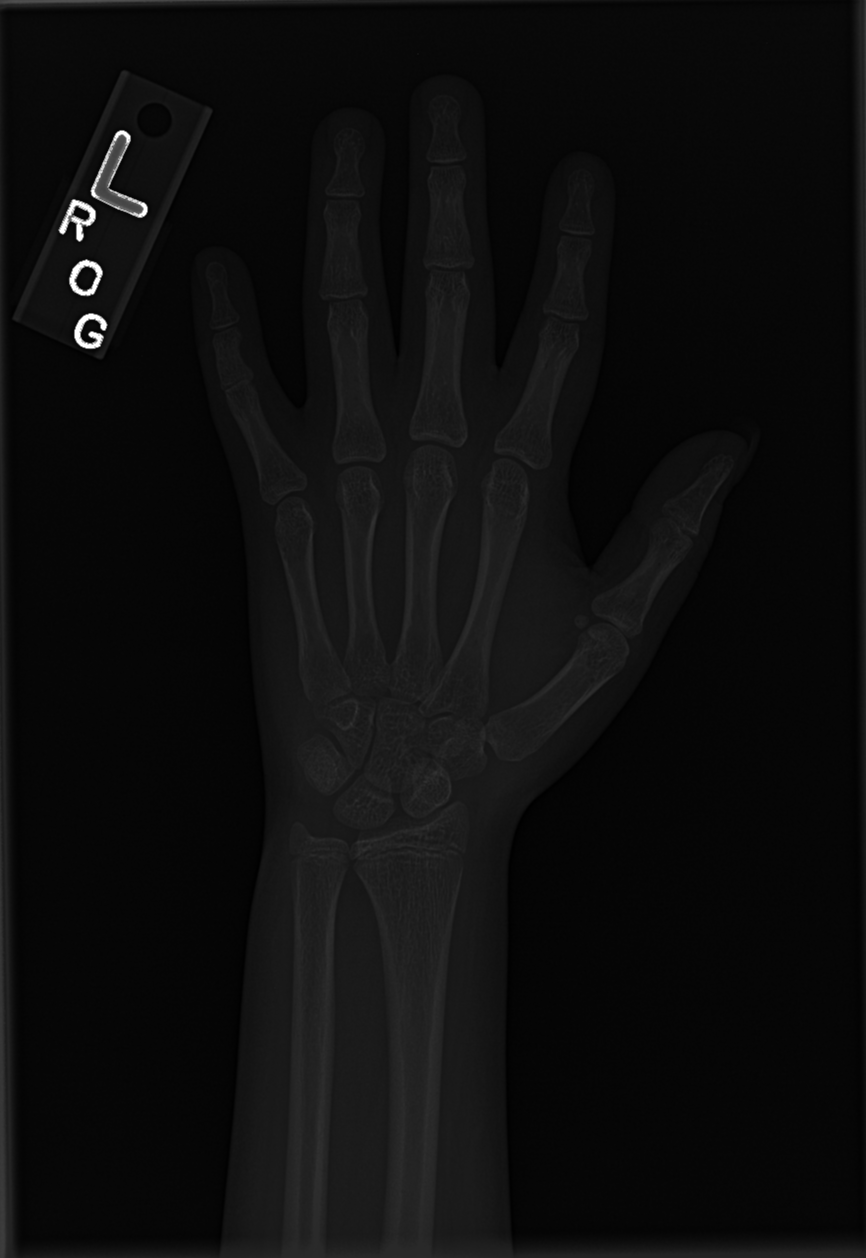

## Classes
- 0_49
- 50_99
- 100_149
- 150_199
- 200_249

### Configs

In [ ]:
# Data paths
classes_path = 'annotation.txt'
train_dataset_path = './boneage_training_dataset_subfolders_50/train'
test_dataset_path = './boneage_training_dataset_subfolders_50/valid'
path_to_model = '/models'

# Training configs
input_dim = 299   # 299, 224
epochs = 40
lr=0.01
head = 'xception' # xception, vgg16, inceptionv3, densenet121

### The important libraries

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from glob import glob
import os

### Download the dataset

In [ ]:
!wget https://www.dropbox.com/scl/fi/9ln0hnw2j8w8l5jobh4y3/boneage_training_dataset_subfolders_50.zip?rlkey=eg5oddm0lyugf6pq7cuj58i9k

--2023-09-23 09:07:59--  https://www.dropbox.com/scl/fi/df77zbkzl1z5tslxiljh6/boneage_training_dataset_subfolders_50.zip?rlkey=i7ifg7z9o7n2lka7unof32hro
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/df77zbkzl1z5tslxiljh6/boneage_training_dataset_subfolders_50.zip?rlkey=i7ifg7z9o7n2lka7unof32hro [following]
--2023-09-23 09:07:59--  https://www.dropbox.com/e/scl/fi/df77zbkzl1z5tslxiljh6/boneage_training_dataset_subfolders_50.zip?rlkey=i7ifg7z9o7n2lka7unof32hro
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc92552c6078a11e9fb023916440.dl.dropboxusercontent.com/cd/0/inline/CERzUWnGsTAPGV8oPAWHwNNHGDUjiv3YqLi-8nxJFsIR8YJWbMnlK7J2GW5aHYcqB0RXVL89J4M8ngRrLFW2NPhloAioNPCRI8zyZrm4z1YxVBnyRWlKi0Dsoh_KQtgIWnds

In [ ]:
import os

os.rename('boneage_training_dataset_subfolders_50.zip?rlkey=eg5oddm0lyugf6pq7cuj58i9k', 'boneage_training_dataset_subfolders_50.zip')

In [ ]:
#import zipfile module
from zipfile import ZipFile

with ZipFile('boneage_training_dataset_subfolders_50.zip', 'r') as f:

  #extract in current directory
  f.extractall()

### Prepare the datasets (images and labels)

In [ ]:
def return_ds(input_dir):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        input_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(input_dim, input_dim),
        batch_size=16,
    label_mode='categorical',
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        input_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(input_dim, input_dim),
        batch_size=8,
    label_mode='categorical',
    )
    return train_ds, val_ds

### Return the model to be used for classification

In [ ]:
def return_model(input_dim, nb_classes, freeze=False, head=None):
    if head == 'xception' or head == 'Xception':
        base_model = Xception(include_top=False, weights='imagenet', input_shape=(input_dim, input_dim, 3))

    if head == 'vgg16' or head == 'VGG16':
        base_model = VGG16(include_top=False, weights='imagenet', input_shape=(input_dim, input_dim, 3))

    if head == 'inceptionv3' or 'Inceptionv3' or 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(input_dim, input_dim, 3))

    if head == 'densenet121':
        base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(input_dim, input_dim, 3))

    if not head:
        print('Please choose the pretrained model')

    print('Chosen model is:', head)

    if freeze:
        for layer in base_model.layers:
            layer.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='sigmoid')(x)

    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.inputs, outputs=predictions)

    return model

### Return the Class names from the *`annotation.txt`*

In [ ]:
def return_classes(classes_path):
    with open(classes_path, 'r') as f:
        classes = f.readlines()
        classes = list(map(lambda x: x.strip(), classes))

    return classes

### Train the model

In [ ]:
os.makedirs(path_to_model, exist_ok=True)

classes = return_classes(classes_path)
train_ds, val_ds = return_ds(train_dataset_path)
model = return_model(input_dim, len(classes), head=head, freeze=True)

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=lr), metrics=['accuracy'])
save_weights = ModelCheckpoint(filepath=f'{path_to_model}/{head}_{epochs}.h5', monitor='val_accuracy',
                                  verbose=1, save_best_only=True, save_weights_only=False, mode='max')

model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[save_weights])

Found 11801 files belonging to 5 classes.
Using 9441 files for training.
Found 11801 files belonging to 5 classes.
Using 2360 files for validation.
87910968/87910968 [==============================] - 5s 0us/step
Chosen model is: xception
Epoch 1/40
591/591 [==============================] - ETA: 0s - loss: 585.7947 - accuracy: 0.3276
Epoch 1: val_accuracy improved from -inf to 0.36695, saving model to /models/xception_40.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


591/591 [==============================] - 68s 92ms/step - loss: 585.7947 - accuracy: 0.3276 - val_loss: 1667.1930 - val_accuracy: 0.3669
Epoch 2/40
588/591 [============================>.] - ETA: 0s - loss: 529.6708 - accuracy: 0.3418
Epoch 2: val_accuracy did not improve from 0.36695
591/591 [==============================] - 52s 87ms/step - loss: 529.1439 - accuracy: 0.3415 - val_loss: 1061.0283 - val_accuracy: 0.3669
Epoch 3/40
590/591 [============================>.] - ETA: 0s - loss: 494.9997 - accuracy: 0.3535
Epoch 3: val_accuracy improved from 0.36695 to 0.42034, saving model to /models/xception_40.h5
591/591 [==============================] - 53s 88ms/step - loss: 494.9473 - accuracy: 0.3536 - val_loss: 259.5616 - val_accuracy: 0.4203
Epoch 4/40
591/591 [==============================] - ETA: 0s - loss: 475.6413 - accuracy: 0.3621
Epoch 4: val_accuracy did not improve from 0.42034
591/591 [==============================] - 52s 87ms/step - loss: 475.6413 - accuracy: 0.3621 - v



---



# Predictions
This section is for predicting the bone age using the trained model.

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
import cv2

In [ ]:
class Predictor:
    def __init__(self, input_dim, classes_path, model=None, test_ds = None):
        self.model = model
        self.input_dim = input_dim
        self.test_ds = test_ds
        self.classes_path = classes_path

    def return_classes(self):
        with open(self.classes_path, 'r') as f:
            classes = f.readlines()
            classes = list(map(lambda x: x.strip(), classes))

        return classes

    def return_model(self, model_path):
        self.model = load_model(model_path)

    def return_test_ds(self, input_dir):
        test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            input_dir,
            seed=42,
            image_size=(self.input_dim, self.input_dim),
            batch_size=16,
        label_mode='categorical',
        )
        return test_ds


    def predict_one_image(self, img_path):
        classes = self.return_classes()
        img = image.load_img(img_path, target_size=(self.input_dim, self.input_dim))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        prediction = self.model.predict(img_batch)
        predicted_class_idx = np.argmax(prediction)
        probability = np.max(prediction)
        predicted_class = classes[predicted_class_idx]

        return predicted_class, probability

    def predict_one_array(self, array):
        classes = self.return_classes()
        img_array = image.img_to_array(array)
        img_batch = np.expand_dims(img_array, axis=0)
        prediction = self.model.predict(img_batch)
        predicted_class_idx = np.argmax(prediction)
        probability = np.max(prediction)
        predicted_class = classes[predicted_class_idx]

        return predicted_class, probability

    def predict_directory(self, input_dir):
        self.test_ds = self.return_test_ds(input_dir)
        score = self.model.evaluate(self.test_ds, verbose=0)

        return f"La loss: {score[0]}\nL'accuracy: {score[1]}"  # loss, accuracy

    def prediction_video(self, video_path, show=False, output_path='output_video.mp4'):
        video = cv2.VideoCapture(video_path)
        success,image = video.read()

        frameSize = (image.shape[1], image.shape[0])
        out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), 30, frameSize)
        x,y,w,h = 0,0,650,150

        while success:
            success,image = video.read()
            resized = cv2.resize(image, (self.input_dim, self.input_dim))
            prediction = self.predict_one_array(resized)
            cv2.rectangle(image, (x,x), (x + w, y + h), (0,0,0), -1)
            cv2.putText(image, prediction[0], org=(x + int(w/10),y + int(h/1.5)), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=4, color=(255,255,255), thickness=7)
            if show:
                cv2.imshow('Output', image)

            out.write(image)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

        video.release()
        out.release()
        cv2.destroyAllWindows()

    def predict_webcam(self, show=False, output_path='output_video.mp4'):
        video = cv2.VideoCapture(0)
        success,image = video.read()

        frameSize = (image.shape[1], image.shape[0])
        out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), 30, frameSize)
        x,y,w,h = 0,0,650,150

        while success:
            success,image = video.read()
            resized = cv2.resize(image, (self.input_dim, self.input_dim))
            prediction = self.predict_one_array(resized)
            cv2.rectangle(image, (x,x), (x + w, y + h), (0,0,0), -1)
            cv2.putText(image, prediction[0], org=(x + int(w/10),y + int(h/1.5)), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=4, color=(255,255,255), thickness=7)
            if show:
                cv2.imshow('Output', image)

            out.write(image)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

        video.release()
        out.release()
        cv2.destroyAllWindows()

In [ ]:
## Paths
img_path = "/content/boneage_training_dataset_subfolders_50/val/0_49/1378.png"

## Define the model (instance)
instance = Predictor(input_dim, classes_path)
instance.return_model(f'{path_to_model}/{head}_{epochs}.h5')

## Prediction for one image
predictions = instance.predict_one_image(img_path)
print(predictions)

1/1 [==============================] - 1s 1s/step
('50_99', 1.0)
